In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np

sns.set_theme()

In [3]:
import os

PLOT_DIR = "example-plots"

if not(os.path.exists(PLOT_DIR)):
    os.mkdir(PLOT_DIR)

In [17]:
# Load data
results_files = [
    "20210915-162804.csv", 
    "20210915-111700.csv", 
    "results-compilespace.csv",
]

df_raw = pd.concat(map(lambda f: pd.read_csv(f"results/{f}"), results_files), ignore_index=True)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606 entries, 0 to 605
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Benchmark                 606 non-null    object 
 1   Mode                      312 non-null    object 
 2   Threads                   312 non-null    float64
 3   Samples                   312 non-null    float64
 4   Score                     606 non-null    float64
 5   Score Error (99.9%)       312 non-null    float64
 6   Unit                      312 non-null    object 
 7   Param: metaborgVersion    312 non-null    object 
 8   Param: optimisationLevel  606 non-null    int64  
 9   Param: problemSize        606 non-null    int64  
dtypes: float64(4), int64(2), object(4)
memory usage: 47.5+ KB


In [18]:
for col in ["Score", "Score Error (99.9%)"]:
    if col in df_raw and df_raw[col].dtype == object:
        df_raw[col] = df_raw[col].map(lambda s: s.replace(',', '.'), na_action="ignore").astype(float)

# df_raw

In [19]:
df_raw["Param: optimisationLevel"] = df_raw["Param: optimisationLevel"].astype("string")

In [20]:
df = df_raw[df_raw.Benchmark.str.endswith("jfr") == False].copy()
df

,Benchmark,Mode,Threads,Samples,Score,Score Error (99.9%),Unit,Param: metaborgVersion,Param: optimisationLevel,Param: problemSize
0,benchmark.stratego2.compilation.java.Benchexpr...,ss,1.0,15.0,0.396320,0.108810,s/op,2.6.0-SNAPSHOT,2,10
1,benchmark.stratego2.compilation.java.Benchexpr...,ss,1.0,15.0,0.371094,0.091314,s/op,2.6.0-SNAPSHOT,2,11
2,benchmark.stratego2.compilation.java.Benchexpr...,ss,1.0,15.0,0.342439,0.082237,s/op,2.6.0-SNAPSHOT,2,12
3,benchmark.stratego2.compilation.java.Benchexpr...,ss,1.0,15.0,0.332852,0.096456,s/op,2.6.0-SNAPSHOT,2,13
4,benchmark.stratego2.compilation.java.Benchexpr...,ss,1.0,15.0,0.318037,0.071669,s/op,2.6.0-SNAPSHOT,2,14
...,...,...,...,...,...,...,...,...,...,...
601,benchmark.stratego2.compilation.stratego.Sieve...,NaN,NaN,NaN,128611.000000,NaN,NaN,NaN,4,1000
602,benchmark.stratego2.compilation.stratego.Sieve...,NaN,NaN,NaN,124168.000000,NaN,NaN,NaN,4,2000
603,benchmark.stratego2.compilation.stratego.Sieve...,NaN,NaN,NaN,128760.000000,NaN,NaN,NaN,4,2000
604,benchmark.stratego2.compilation.stratego.Sieve...,NaN,NaN,NaN,124159.000000,NaN,NaN,NaN,4,10000


In [21]:
df["Stage"] = df["Benchmark"].str.rpartition('.')[2]
df["Problem"] = df["Benchmark"].str.split('.').map(lambda l: l[-2])

In [60]:
## Plot-specific settings
configs = [
    {
        "problems": {"Benchexpr", "Bubblesort", "Factorial", "Fibonacci", "Hanoi", "Mergesort", "Quicksort", "Sieve"},
        "stages": {"run"},
        "settings": {"yscale": "log"}
    },
    {
        # Apply to all problems
        "stages": {"compileStratego", "compileJava", "Java space", "Class space"},
        "settings": {"ylim": (0, None)}
    },
    {
        "stages": {"Java space", "Class space"},
        "settings": {"ylabel": "Size (bytes)"}
    }
]

In [61]:
from pandas.core.common import flatten

def configure_grid(g: sns.FacetGrid, problem=None):
    ## Global settings
    g.set_ylabels("Time (s)")
    g.set_xlabels("Input size")

    for ax in flatten(g.axes):
        ax.get_xaxis().set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

    # Specific settings
    try:
        for (row_val, col_val), ax in g.axes_dict.items():
            for config in configs:
                if "problems" not in config or row_val in config["problems"]:
                    if "stages" not in config or col_val in config["stages"]:
                        ax.set(**config["settings"])
    except (ValueError):
        for col_val, ax in g.axes_dict.items():
            for config in configs:
                if "problems" not in config or problem in config["problems"]:
                    if "stages" not in config or col_val in config["stages"]:
                        ax.set(**config["settings"])
    finally:
        return g

In [38]:
df_scaledproblem = df[df["Param: problemSize"] != -1]

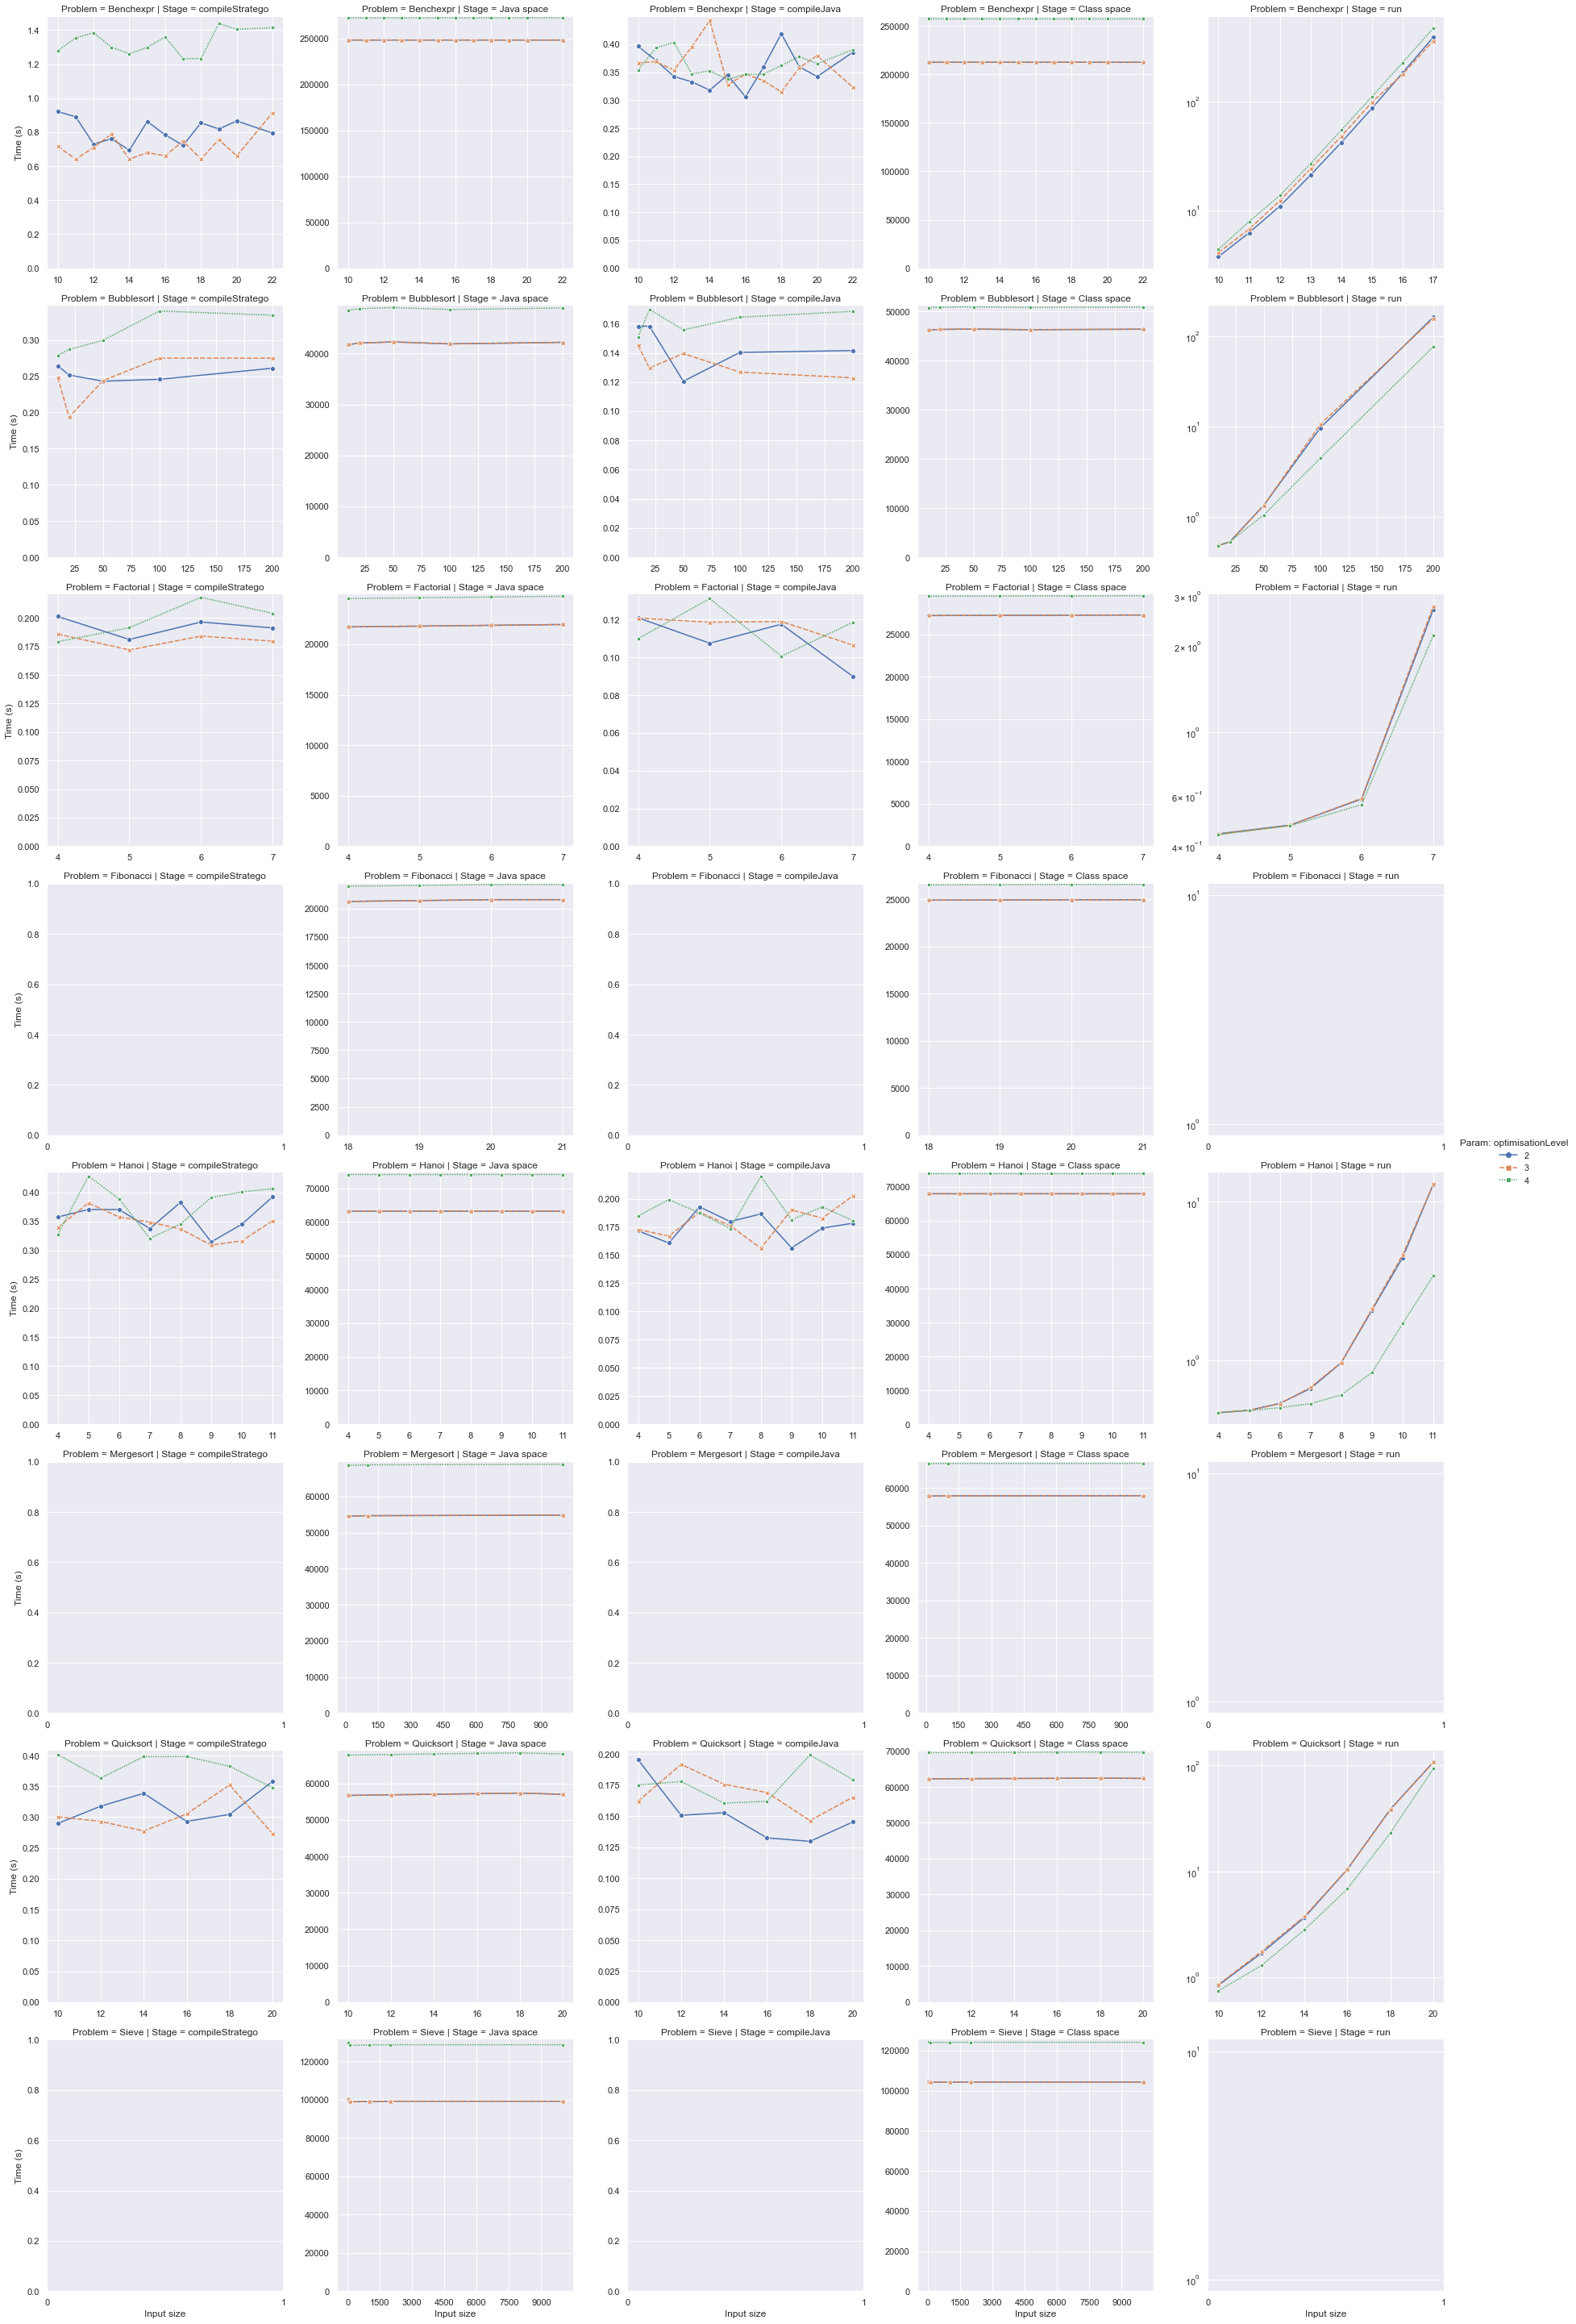

In [39]:
g = configure_grid(sns.relplot(
    data=df_scaledproblem,
    x="Param: problemSize",
    y="Score",
    row="Problem",
    row_order=np.sort(np.unique(df_scaledproblem["Problem"].values)),
    col="Stage",
    col_order=[s for s in ["compileStratego", "Java space", "compileJava", "Class space", "run"] if s in df_scaledproblem["Stage"].values],
    style="Param: optimisationLevel",
    hue="Param: optimisationLevel",
    hue_order=["2", "3", "4"],
    kind="line",
#     err_style="band",
    markers=True,
    facet_kws=dict(
        sharex=False, 
        sharey=False,
    ),
))

# TODO Include strj runtime -> with and without fusion

# Save figure to file
plt.savefig(f"{PLOT_DIR}/{'_'.join(results_files)}-scaled.png", transparent=False)

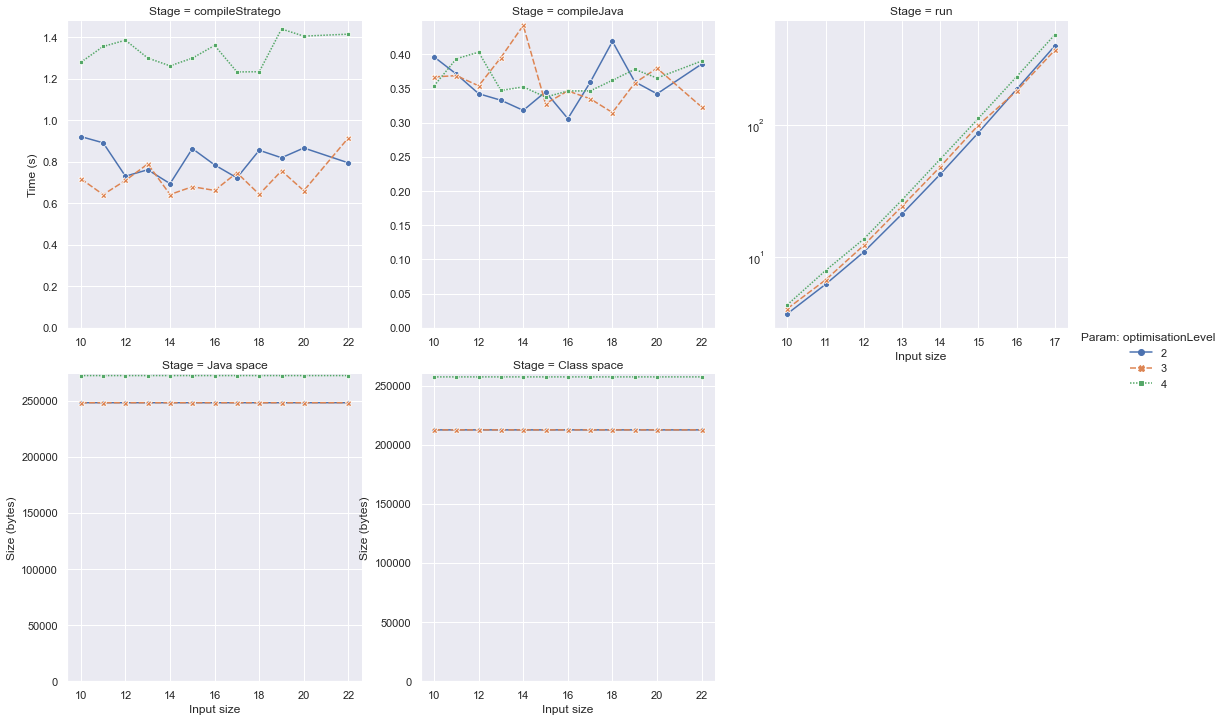

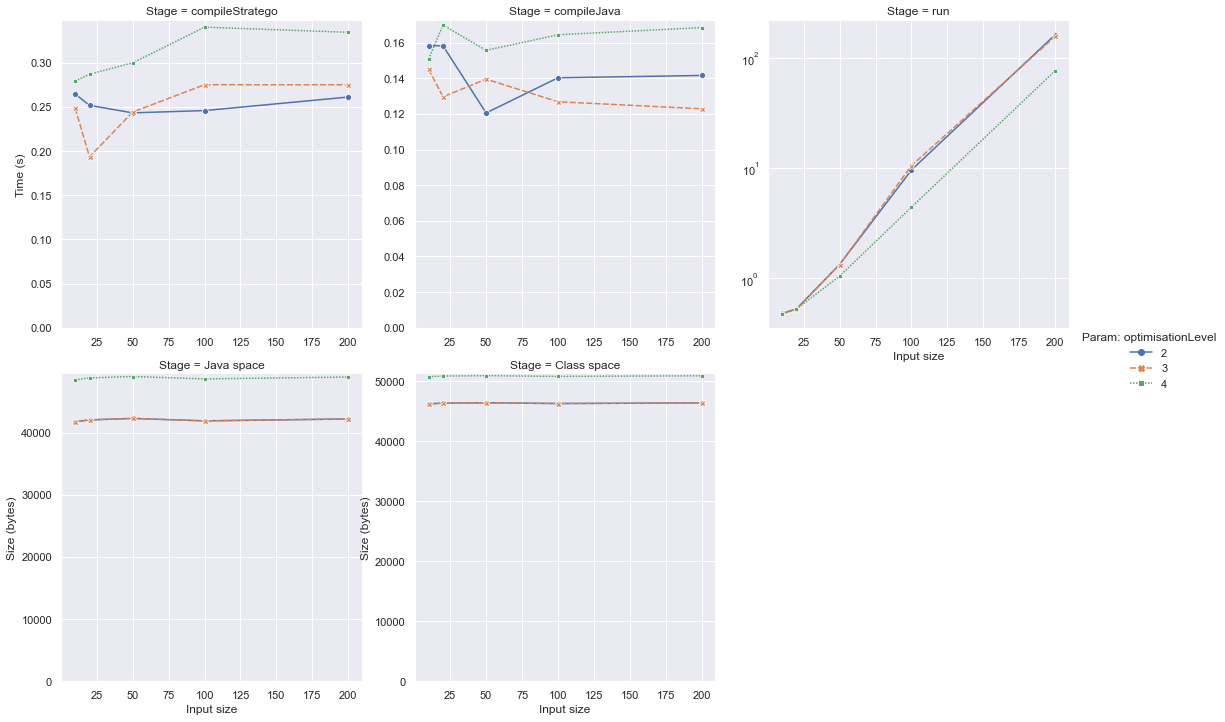

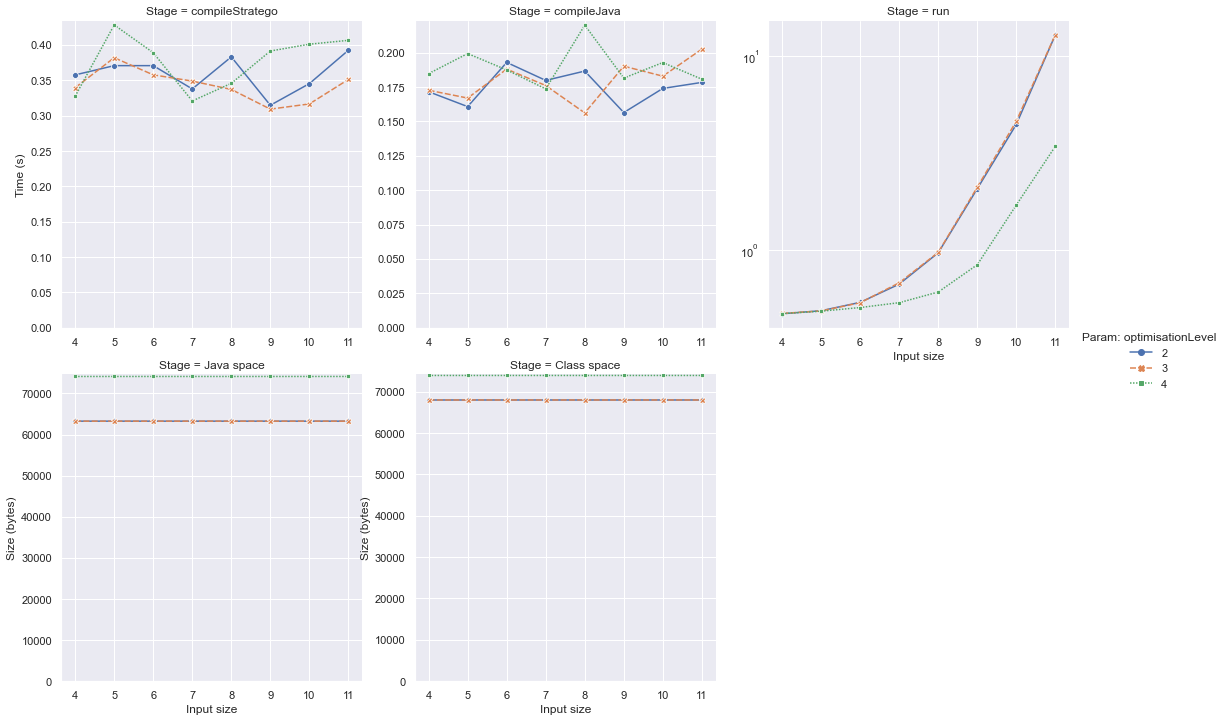

In [62]:
for problem in ["Benchexpr", "Bubblesort", "Hanoi"]:
    df_problem = df_scaledproblem[df_scaledproblem["Problem"] == problem]

    g = configure_grid(sns.relplot(
        data=df_problem,
        x="Param: problemSize",
        y="Score",
#         row="Problem",
#         row_order=np.sort(np.unique(df_problem["Problem"].values)),
        col_wrap=3,
        col="Stage",
        col_order=[s for s in ["compileStratego", "compileJava", "run", "Java space", "Class space"] if s in df_problem["Stage"].values],
        style="Param: optimisationLevel",
        hue="Param: optimisationLevel",
        hue_order=["2", "3", "4"],
        kind="line",
    #     err_style="band",
        markers=True,
        facet_kws=dict(
            sharex=False, 
            sharey=False,
        ),
    ), problem)
    

    # TODO Include strj runtime -> with and without fusion

    # Save figure to file
    plt.savefig(f"{PLOT_DIR}/{'_'.join(results_files)}-{problem}.png")

In [25]:
df_unscaledproblem = df[df["Param: problemSize"] == -1]

print(df_unscaledproblem.to_latex(
    columns=["Problem", "Stage", "Samples", "Score", "Score Error (99.9%)", "Param: optimisationLevel"]
))

df_unscaledproblem

\begin{tabular}{lllrrrl}
\toprule
{} &            Problem &            Stage &  Samples &         Score &  Score Error (99.9\%) & Param: optimisationLevel \\
\midrule
51  &              Calls &      compileJava &     15.0 &      0.157694 &             0.068597 &                        2 \\
52  &              Calls &      compileJava &     15.0 &      0.144761 &             0.036396 &                        3 \\
53  &              Calls &      compileJava &     15.0 &      0.147326 &             0.060262 &                        4 \\
159 &              Calls &  compileStratego &     15.0 &      0.213802 &             0.034269 &                        2 \\
160 &              Calls &  compileStratego &     15.0 &      0.200271 &             0.032757 &                        3 \\
161 &              Calls &  compileStratego &     15.0 &      0.214129 &             0.041291 &                        4 \\
255 &              Calls &              run &     15.0 &      0.438896 &             0.00

,Benchmark,Mode,Threads,Samples,Score,Score Error (99.9%),Unit,Param: metaborgVersion,Param: optimisationLevel,Param: problemSize,Stage,Problem
51,benchmark.stratego2.compilation.java.Calls.com...,ss,1.0,15.0,0.157694,0.068597,s/op,2.6.0-SNAPSHOT,2,-1,compileJava,Calls
52,benchmark.stratego2.compilation.java.Calls.com...,ss,1.0,15.0,0.144761,0.036396,s/op,2.6.0-SNAPSHOT,3,-1,compileJava,Calls
53,benchmark.stratego2.compilation.java.Calls.com...,ss,1.0,15.0,0.147326,0.060262,s/op,2.6.0-SNAPSHOT,4,-1,compileJava,Calls
159,benchmark.stratego2.compilation.stratego.Calls...,ss,1.0,15.0,0.213802,0.034269,s/op,2.6.0-SNAPSHOT,2,-1,compileStratego,Calls
160,benchmark.stratego2.compilation.stratego.Calls...,ss,1.0,15.0,0.200271,0.032757,s/op,2.6.0-SNAPSHOT,3,-1,compileStratego,Calls
161,benchmark.stratego2.compilation.stratego.Calls...,ss,1.0,15.0,0.214129,0.041291,s/op,2.6.0-SNAPSHOT,4,-1,compileStratego,Calls
255,benchmark.stratego2.execution.Calls.run,ss,1.0,15.0,0.438896,0.006756,s/op,2.6.0-SNAPSHOT,2,-1,run,Calls
256,benchmark.stratego2.execution.Calls.run,ss,1.0,15.0,0.436931,0.007804,s/op,2.6.0-SNAPSHOT,3,-1,run,Calls
257,benchmark.stratego2.execution.Calls.run,ss,1.0,15.0,0.440525,0.008237,s/op,2.6.0-SNAPSHOT,4,-1,run,Calls
346,benchmark.stratego2.compilation.stratego.Calls...,NaN,NaN,NaN,36895.000000,NaN,NaN,NaN,2,-1,Class space,Calls
